In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 9

## Torch Datasets
- Ionosphere



## Import Statements

In [2]:
###-----------------
### Import libraries
###-----------------
from pathlib import Path         # Import Path for file system path operations and management
import numpy as np               # Import NumPy for numerical computations and array operations
import pandas as pd              # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns            # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             f1_score)                 # to calculate various metric

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

2025-11-15 17:34:10.935607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# ###------------------
# ### Global Parameters
# ###------------------

# Directories
inpDir = Path('..') / '..' / 'input'
outDir = Path('..') / 'output'
modelDir = Path('..') / 'models'
subDir = 'ionosphere'
fileName = 'ionosphere.data'

RANDOM_STATE = 24 
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
torch.manual_seed(RANDOM_STATE)


EPOCHS = 200
BATCH_SIZE = 16
TEST_SIZE  = 0.2 # Size of test data
TRAIN_SIZE = int(18 * BATCH_SIZE)

ALPHA = 0.001
WEIGHT_DECAY = 0.001  # AdamW 
PATIENCE = 20         # Early stopping
LR_FACTOR = 0.1       # Reduction on LR Factor
LR_PATIENCE = 5       # How long should I wait
MIN_LR = 1e-6         # Min

# Parameters for plotting
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
18147*0.8/32

453.675

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
data_df = pd.read_csv(inpDir/subDir/fileName)
data_df.head()

,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.1,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
0,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
1,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
2,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
3,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g
4,1,0,0.02337,-0.00592,-0.09924,-0.11949,-0.00763,-0.11824,0.14706,0.06637,...,-0.01535,-0.03240,0.09223,-0.07859,0.00732,0.00000,0.00000,-0.00039,0.12011,b


In [7]:
train_df, test_df = train_test_split(data_df,
                                     stratify=data_df[data_df.columns[-1]],
                                     train_size=TRAIN_SIZE,
                                     #test_size=TEST_SIZE,
                                     random_state=RANDOM_STATE)
train_df.shape, test_df.shape

((288, 35), (62, 35))

### Custom Dataset

In [8]:
class Transformers:
    _instance = None

    def __init__(self):
        if Transformers._instance is not None:
            raise Exception ('Transformers is Singleton Class')
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()

    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = Transformers()
        return cls._instance

In [9]:
class IonoDS(Dataset):
    transformers = Transformers.get_instance() # Protected variable

    def __init__(self, 
                 dataframe, 
                 device = device, 
                 is_train = True, 
                 label_col = None):
        
        super(IonoDS, self).__init__()

        self.df = dataframe
        self.device = device
        self.is_train= is_train
        self.scaler = self.transformers.scaler
        self.encoder = self.transformers.encoder
        self.label_col = label_col

        y = self.df[label_col].to_numpy()
        X = self.df.drop(label_col, axis = 1)
        if self.is_train:
            self.labels = self.encoder.fit_transform(y)
            self.features = self.scaler.fit_transform(X)
        else:
            self.labels = self.encoder.transform(y)
            self.features = self.scaler.transform(X)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        
        feature = torch.tensor(feature, dtype=torch.float32, device=self.device)
        label = torch.tensor(label, dtype=torch.int64, device=self.device)

        return feature, label


In [10]:
train_df = train_df.reset_index(drop=True)
train_df.head()

,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.1,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
0,1,0,0.84557,-0.08580,-0.31745,-0.80553,-0.08961,-0.56435,0.80648,0.04576,...,-0.03718,0.70882,-0.25288,0.77884,-0.14109,-0.21354,-0.78170,-0.18494,-0.59867,b
1,1,0,0.45455,0.09091,0.63636,0.09091,0.27273,0.18182,0.63636,0.00000,...,-0.09091,0.34442,-0.01768,0.27273,0.00000,0.36364,0.00000,0.28985,-0.01832,g
2,1,0,0.93147,0.29282,0.79917,0.55756,0.59952,0.71596,0.26203,0.92651,...,-0.46906,-0.65165,-0.69556,-0.41223,-0.85725,-0.13590,-0.93953,0.10007,-0.94823,g
3,1,0,1.00000,-0.05529,1.00000,-1.00000,0.50000,-0.11111,0.36111,-0.22222,...,-0.27778,1.00000,-0.57092,1.00000,-0.27778,1.00000,-0.63156,1.00000,-0.65935,b
4,1,0,1.00000,0.01709,0.96215,-0.03142,1.00000,-0.03436,1.00000,-0.05071,...,-0.22083,0.96490,-0.20243,0.94599,-0.17123,0.96436,-0.22561,0.87011,-0.23296,g


In [11]:
test_df = test_df.reset_index(drop=True)
test_df.head()

,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.1,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
0,1,0,1.00000,0.23058,1.00000,-0.78509,1.00000,-0.10401,1.00000,0.15414,...,-0.01253,0.96238,-0.04597,0.91165,0.03885,1.00000,-0.13722,0.96523,-0.11717,g
1,1,0,0.01975,0.00705,0.04090,-0.00846,0.02116,0.01128,0.01128,0.04372,...,-0.01269,0.01834,-0.01128,0.00564,-0.01551,-0.01693,-0.02398,0.00705,0.00000,b
2,1,0,0.57540,-0.03175,0.75198,-0.05357,0.61508,-0.01190,0.53968,0.03373,...,0.03968,0.61291,-0.01237,0.61706,-0.13492,0.68849,-0.01389,0.62500,-0.03175,g
3,1,0,0.74084,0.04974,0.79074,0.02543,0.78575,0.03793,0.66230,0.09948,...,0.15445,0.64158,0.13608,0.65707,0.17539,0.59759,0.14697,0.57455,0.15114,g
4,1,0,1.00000,-0.15899,0.72314,0.27686,0.83443,-0.58388,1.00000,-0.28207,...,0.14803,1.00000,-0.11582,1.00000,-0.11129,1.00000,0.53372,1.00000,-0.57758,g


In [12]:
label_col = train_df.columns[-1]
train_ds = IonoDS(train_df, is_train=True,  label_col=label_col)
test_ds  = IonoDS(test_df,  is_train=False, label_col=label_col)

In [13]:
type(train_df), type(train_ds), type(test_df), type(test_ds), 

(pandas.core.frame.DataFrame,
 __main__.IonoDS,
 pandas.core.frame.DataFrame,
 __main__.IonoDS)

In [14]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) 
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=True) 

# for count, data in enumerate(train_loader):
#     feat, lbl = data
#     print (f'Count: {count}| {feat.shape}, {lbl.shape}')

In [15]:
class Model(nn.Module):

    def __init__(self, input_dim):
        super().__init__()

        dor1 = 0.1
        dor2 = 0.2
        dor3 = 0.3
        dor4 = 0.4

        out_dim_1 = 66
        self.layer1 = nn.Linear(input_dim, out_dim_1)
        self.bn1 = nn.BatchNorm1d(out_dim_1)
        self.actv1 = nn.ReLU()                          
        self.do1 = nn.Dropout(dor1) # output 66

        out_dim_2 = 33
        self.layer2 = nn.Linear(out_dim_1, out_dim_2)
        self.bn2 = nn.BatchNorm1d(out_dim_2)
        self.actv2 = nn.ReLU()                          
        self.do2 = nn.Dropout(dor2)                           # output 33

        out_dim_3 = 16
        self.layer3 = nn.Linear(out_dim_2, out_dim_3)
        self.bn3 = nn.BatchNorm1d(out_dim_3)
        self.actv3 = nn.ReLU()                          
        self.do3 = nn.Dropout(dor3)                          # output 16

        out_dim_4 = 8
        self.layer4 = nn.Linear(out_dim_3, out_dim_4)
        self.bn4 = nn.BatchNorm1d(out_dim_4)
        self.actv4 = nn.ReLU()                          
        self.do4 = nn.Dropout(dor4)                          # output 8

        self.layer5 = nn.Linear(out_dim_4, 4)           # output 4
        # self.actv5 = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.do1(self.actv1(self.bn1(self.layer1(x))))
        
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.actv2(x)
        x = self.do2(x)

        x = self.do3(self.actv3(self.bn3(self.layer3(x))))
        x = self.do4(self.actv4(self.bn4(self.layer4(x))))
        x = self.layer5(x)
        return x

model = Model(input_dim=34).to(device)
print (model)

Model(
  (layer1): Linear(in_features=34, out_features=66, bias=True)
  (bn1): BatchNorm1d(66, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.1, inplace=False)
  (layer2): Linear(in_features=66, out_features=33, bias=True)
  (bn2): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv2): ReLU()
  (do2): Dropout(p=0.2, inplace=False)
  (layer3): Linear(in_features=33, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv3): ReLU()
  (do3): Dropout(p=0.3, inplace=False)
  (layer4): Linear(in_features=16, out_features=8, bias=True)
  (bn4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv4): ReLU()
  (do4): Dropout(p=0.4, inplace=False)
  (layer5): Linear(in_features=8, out_features=4, bias=True)
)


In [ ]:
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       min_lr=MIN_LR,
                                                       factor=LR_FACTOR, 
                                                       patience=PATIENCE, 
                                                       mode='min')

loss, tloss = [], []
acc, tacc = [], []
n_epoch = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)

    train_loss = train_loss /len(train_ds)
    train_acc = train_acc /len(train_ds)
    loss.append(train_loss)
    acc.append(train_acc)

    with torch.inference_mode():
        model.eval()
        test_loss = 0.0
        test_acc = 0.0

        for i, data in enumerate(test_loader):
            inputs, labels = data
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            batch_loss = loss_fn(outputs, labels)
            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc * inputs.size(0)

        test_loss = test_loss /len(test_ds)
        test_acc = test_acc /len(test_ds)
        
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)

    scheduler.step(test_loss)
    
    if epoch%10 == 0:
        print (f'Epoch:{epoch:03d} | Loss: {train_loss:.4f} - {test_loss:.4f} ' +
               f'| Acc: {train_acc:.4f} - {test_acc:.4f}')


Epoch:000 | Loss: 1.6888 - 1.4300 | Acc: 0.2188 - 0.6290
Epoch:010 | Loss: 0.7682 - 0.6420 | Acc: 0.7743 - 0.8710
Epoch:020 | Loss: 0.5666 - 0.2830 | Acc: 0.8403 - 0.9516
Epoch:030 | Loss: 0.3237 - 0.1745 | Acc: 0.9306 - 0.9516
Epoch:040 | Loss: 0.2426 - 0.1283 | Acc: 0.9306 - 0.9677
Epoch:050 | Loss: 0.1843 - 0.1193 | Acc: 0.9549 - 0.9516
Epoch:060 | Loss: 0.2284 - 0.0712 | Acc: 0.9306 - 0.9839
Epoch:070 | Loss: 0.1745 - 0.0692 | Acc: 0.9514 - 0.9516
Epoch:080 | Loss: 0.1941 - 0.0481 | Acc: 0.9410 - 1.0000
Epoch:090 | Loss: 0.1881 - 0.0617 | Acc: 0.9201 - 0.9839
Epoch:100 | Loss: 0.1402 - 0.0909 | Acc: 0.9653 - 0.9516
Epoch:110 | Loss: 0.1418 - 0.0799 | Acc: 0.9583 - 0.9677
Epoch:120 | Loss: 0.1784 - 0.0715 | Acc: 0.9306 - 0.9677
Epoch:130 | Loss: 0.1458 - 0.0712 | Acc: 0.9618 - 0.9677
Epoch:140 | Loss: 0.1448 - 0.0756 | Acc: 0.9410 - 0.9677
Epoch:150 | Loss: 0.1132 - 0.0774 | Acc: 0.9549 - 0.9677
Epoch:160 | Loss: 0.1414 - 0.0736 | Acc: 0.9549 - 0.9677
Epoch:170 | Loss: 0.1658 - 0.07

,epoch,loss,test_loss,acc,test_acc
0,0,1.688803,1.429959,0.218750,0.629032
1,1,1.529330,1.334842,0.371528,0.629032
2,2,1.405150,1.248498,0.388889,0.629032
3,3,1.305578,1.186329,0.506944,0.645161
4,4,1.210809,1.092884,0.576389,0.677419


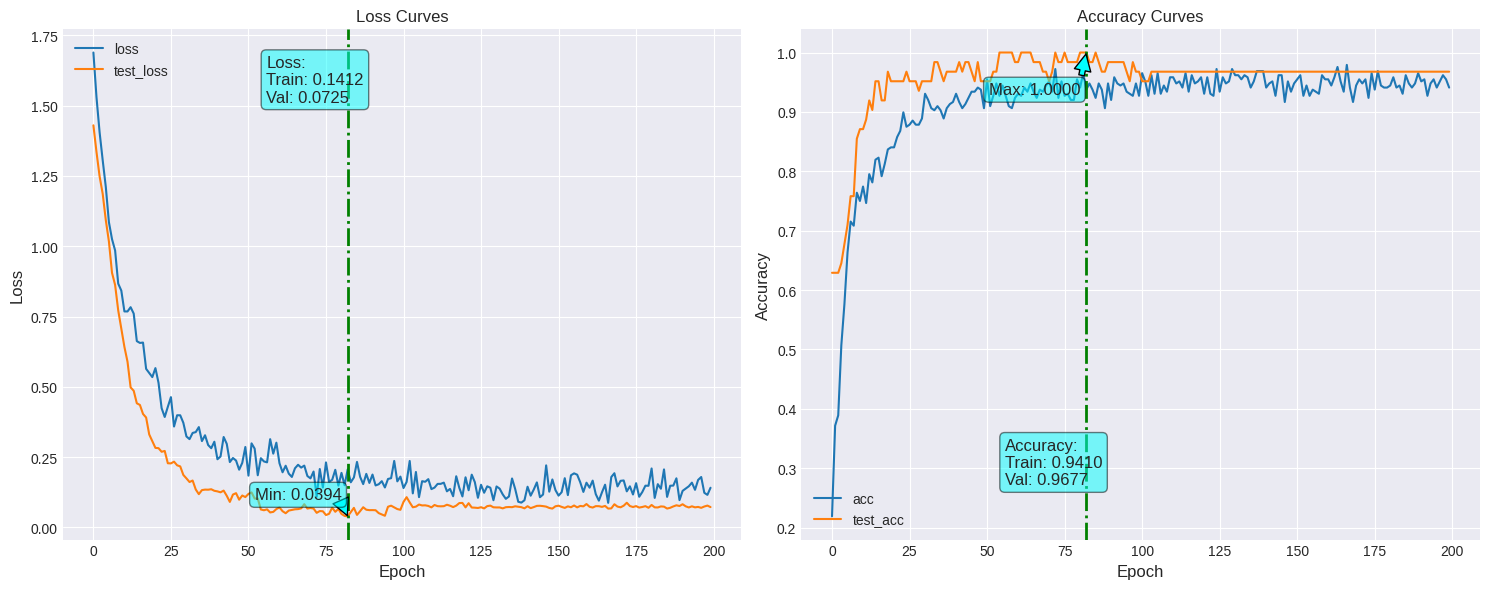

In [17]:
loss_df = pd.DataFrame({'epoch': n_epoch, 
                        'loss': loss,
                        'test_loss': tloss,
                        'acc': acc,
                        'test_acc': tacc})
display(loss_df.head())
fn_plot_torch_hist(loss_df)

### Predictions

In [18]:
y_true, y_pred = [], []
for feat, lbls in train_loader:
    pred = model(feat).detach().cpu().numpy()
    y_true.extend(lbls.cpu().numpy())
    y_pred.extend(pred.argmax(axis=1))

print (f'Accuracy: {accuracy_score(y_true, y_pred):.4f}')
print (classification_report(y_true, y_pred))

Accuracy: 0.9931
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       104
           1       0.99      1.00      0.99       184

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



In [19]:
fn_plot_confusion_matrix(y_true, y_pred, class_labels)

NameError: name 'class_labels' is not defined

In [ ]:
y_true, y_pred = [], []
for feat, lbls in test_ds:
    pred = model(feat).numpy()
    y_true.extend(lbls)
    y_pred.extend(pred.argmax(axis=1))

print (f'Accuracy: {accuracy_score(y_true, y_pred):.4f}')
print (classification_report(y_true, y_pred))

In [ ]:
fn_plot_confusion_matrix(y_true, y_pred, class_labels)